In [507]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scoring as sc
import scheduler as sch
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [508]:
# read json file patient_config.json
with open('patient_config.json') as f:
    patient_config = json.load(f)
search_from = 1
doses1 = [1, 0.75, 0.5] if search_from <= 1 else [float(patient_config["d1"])]
doses2 = [1, 0.75, 0.5] if search_from <= 2 else [float(patient_config["d2"])]
doses3 = [1, 0.75, 0.5] if search_from <= 3 else [float(patient_config["d3"])]
doses4 = [1, 0.75, 0.5] if search_from <= 4 else [float(patient_config["d4"])]
plans = [(t1, t2, t3, t4) for t1 in doses1 for t2 in doses2 for t3 in doses3 for t4 in doses4]

In [509]:
start_time = time.time()
print(f"Testing {len(plans)} treatment schedules.")

sols = [sc.score(patient_config, plan) for plan in plans]
sols = [sol for sol in sols if sol is not None]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Found {len(sols)} feasible treatment schedules.")
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

Testing 81 treatment schedules.
Found 81 feasible treatment schedules.
Elapsed Time: 80.7280 seconds


In [510]:
scored_plans = [[*sol["plan"], sc.score_burden(sol["burden_sol"]), sc.score_toxicity(sol["toxicity_sol"]), sch.duration(sol["schedule"])] for sol in sols]
df_sp = pd.DataFrame(scored_plans, columns = ["S1", "S2", "S3", "S4", "burden", "toxicity", "total_time"])
df_sp["total_time"] = df_sp["total_time"].astype(int)
df_sp.head()

,S1,S2,S3,S4,burden,toxicity,total_time
0,1.0,1.0,1.00,1.00,4.159984,1.310171,651
1,1.0,1.0,1.00,0.75,9.457203,1.195157,637
2,1.0,1.0,1.00,0.50,21.459243,1.089038,609
3,1.0,1.0,0.75,1.00,19.224610,1.225464,616
4,1.0,1.0,0.75,0.75,44.808235,1.117979,602


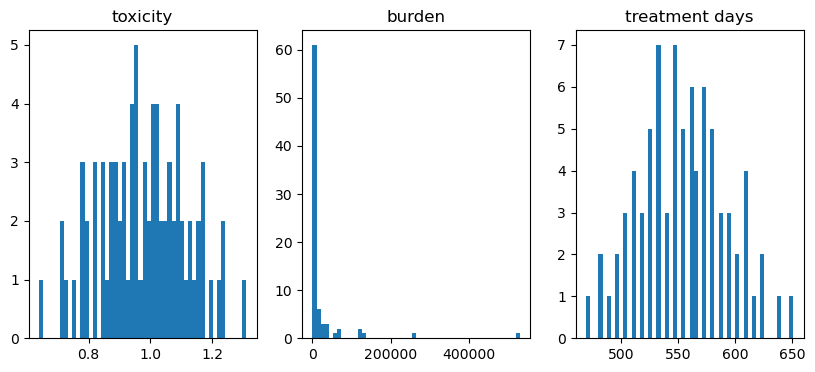

In [511]:
# plot two histograms for cost and benefit
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(df_sp["toxicity"], bins=50)
ax[0].set_title("toxicity");
ax[1].hist(df_sp["burden"], bins=50)
ax[1].set_title("burden");
ax[2].hist(df_sp["total_time"], bins=50)
ax[2].set_title("treatment days");

FileNotFoundError: [Errno 2] No such file or directory: 'out/treatments.png'

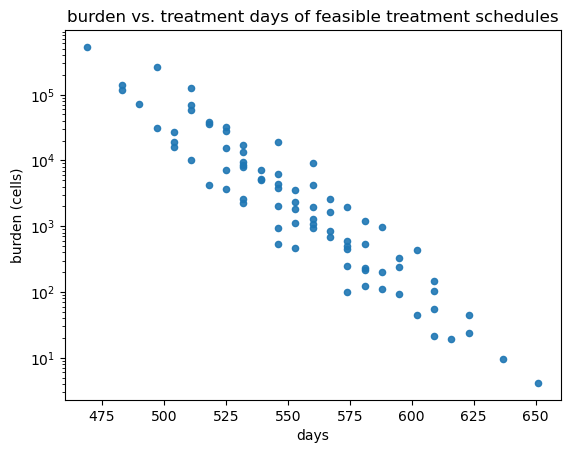

In [512]:
plt.scatter(df_sp["total_time"], df_sp["burden"], s=20, alpha=0.9)

# Add compact labels
for i in range(df_sp.shape[0]):
    values = df_sp.iloc[i][['S1','S2','S3','S4']].values
    label = f"{values[0]:2.0%},{values[1]:2.0%},{values[2]:2.0%},{values[3]:2.0%}"
    label = ""
    plt.text(df_sp.iloc[i]["total_time"], df_sp.iloc[i]["burden"], label, fontsize=7)

# set y to log
plt.yscale("log")
plt.xlabel("days")
plt.ylabel("burden (cells)")
plt.title("burden vs. treatment days of feasible treatment schedules");
plt.savefig("treatments.png")

In [ ]:
time_min = df_sp["total_time"].min()
time_max = df_sp["total_time"].max()
time_range = time_max - time_min
df_sp["time_score"] = 1 - (df_sp["total_time"] - time_min) / time_range

burden_min = np.log(df_sp["burden"].min())
burden_max = np.log(df_sp["burden"].max())
burden_range = burden_max - burden_min
df_sp["burden_score"] = 1- (np.log(df_sp["burden"]) - burden_min) / burden_range

df_sp["score"] = df_sp["time_score"] + df_sp["burden_score"]
df_sp

,S1,S2,S3,S4,burden,toxicity,total_time,time_score,burden_score,score
0,1.0,1.0,1.00,1.00,3.362719,1.245143,644,0.00,1.000000,1.000000
1,1.0,1.0,1.00,0.75,11.485866,1.137958,616,0.16,0.896331,1.056331
2,1.0,1.0,1.00,0.50,39.853570,1.036857,602,0.24,0.791334,1.031334
3,1.0,1.0,0.75,1.00,14.001233,1.165783,609,0.20,0.879618,1.079618
4,1.0,1.0,0.75,0.75,48.398975,1.067393,581,0.36,0.774939,1.134939
...,...,...,...,...,...,...,...,...,...,...
76,0.5,0.5,0.75,0.75,40428.680939,0.816232,497,0.84,0.207138,1.047138
77,0.5,0.5,0.75,0.50,128774.129727,0.713807,483,0.92,0.109364,1.029364
78,0.5,0.5,0.50,1.00,49001.564987,0.838414,511,0.76,0.190908,0.950908
79,0.5,0.5,0.50,0.75,147844.782025,0.731229,483,0.92,0.097708,1.017708


In [ ]:
df_sp.iloc[df_sp["score"].idxmax()]

S1                1.000000
S2                0.750000
S3                0.750000
S4                0.750000
burden          222.983872
toxicity          1.003905
total_time      553.000000
time_score        0.520000
burden_score      0.646014
score             1.166014
Name: 13, dtype: float64

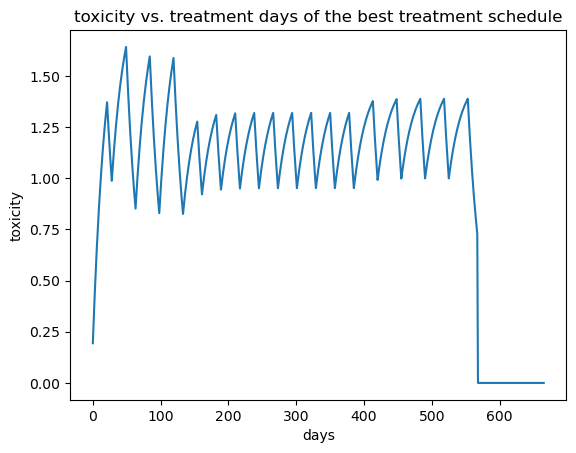

In [ ]:
best_solution = sols[df_sp["score"].idxmax()]
plt.plot(best_solution["toxicity_sol"]);
plt.xlabel("days")
plt.ylabel("toxicity")
plt.title("toxicity vs. treatment days of the best treatment schedule");
plt.savefig("toxicity.png")

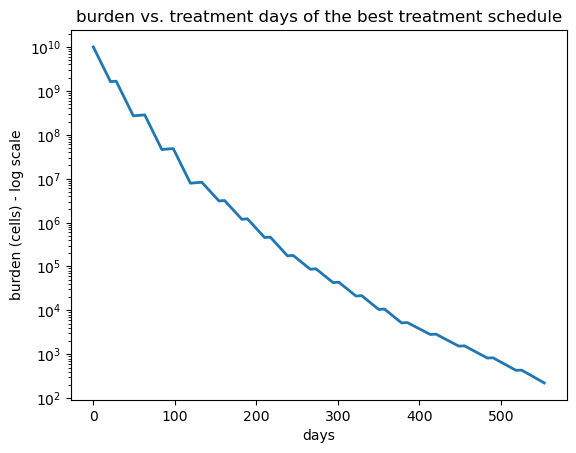

In [ ]:
sol = best_solution["burden_sol"]
plt.plot(sol .t, sol .y.T[:, 0], lw=2);
plt.xlabel("days")
plt.ylabel("burden (cells) - log scale")
plt.yscale("log")
plt.title("burden vs. treatment days of the best treatment schedule");
plt.savefig("burden.png")

In [ ]:
import file_manipulation as fm
cyc_df = fm.cycles_to_df(best_solution["schedule"])
report = fm.cycles_df_to_report(cyc_df)
sch_df = fm.report_to_df(report)
sch_df.to_csv("schedule.csv", index=False)
sch_df

,strike,dose,days
0,1,1.0,21
1,1,break,7
2,1,1.0,21
3,1,break,14
4,1,1.0,21
5,1,break,14
6,1,1.0,21
7,2,0.75,21
8,2,break,7
9,2,0.75,21


In [ ]:
# import visualization as vis
# vis.create_graph(sch_df)